# HACKATHON FESTIVAL ~ !!!


## 14조 / 홍세현, 심영준, 이고은 ... 이름하여 "홍심이조"

### 저희 조는 협업을 위해 Gather Town과 Google Drive를 이용하여 작업하였습니다. 

### about this Kaggle competition ... 

### Description 
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data,   
kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month.   
By solving this competition you will be able to apply and enhance your data science skills.


### Evaluation 
Submissions are evaluated by root mean squared error (RMSE).   
True target values are clipped into [0,20] range.

Submission File

For each id in the test set, you must predict a total number of sales.  
The file should contain a header and have the following format:

# 자, 그럼 이제 시작합니다 ~!

### 14조의 FRAMEWORK ..!! 

프로젝트의 진행 순서는 다음과 같습니다.

- data load
- remove outlier
- merge shops/items/item_category data
- fill 34 months nans with zeros
- add type_code, subtype_code and month columns
- drop useless columns
- set validation data 34 test, 33 validation, less than 33 train
- fit and predict the model

## ✓ 필요한 라이브러리 import 하기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## ✓ 데이터 경로 지정하기

In [2]:
# data_dir = os.getenv('HOME')+'/aiffel/kaggle/Hackathon_0208/data'
data_dir = os.getenv('HOME')+'/workplace/kaggle_contest/competitive-data-science-predict-future-sales/'

train_data_path = join(data_dir, 'sales_train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
item_category_path = join(data_dir,'item_categories.csv')
items_data_path = join(data_dir,'items.csv')
shops_data_path = join(data_dir,'shops.csv')
sub_data_path = join(data_dir,'sample_submission.csv')

## 1. 데이터 살펴보기
## ✓ 데이터 불러오기

In [3]:
train_data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path,index_col=0)
item_category= pd.read_csv(item_category_path)
items = pd.read_csv(items_data_path)
shops =pd.read_csv(shops_data_path)
sub = pd.read_csv(sub_data_path)


print('train data dim : {}'.format(train_data.shape))
print('test data dim : {}'.format(test.shape))
print('item category data dim : {}'.format(item_category.shape))
print('items data dim : {}'.format(items.shape))
print('shops data dim : {}'.format(shops.shape))
print('sub data dim : {}'.format(sub.shape))


train data dim : (2935849, 6)
test data dim : (214200, 2)
item category data dim : (84, 2)
items data dim : (22170, 3)
shops data dim : (60, 2)
sub data dim : (214200, 2)


In [4]:
def eda(data):
    print("----------Top-5- Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)

def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);
    
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)


In [5]:
train_data.head(3) 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [6]:
train_data.tail(3) 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num  

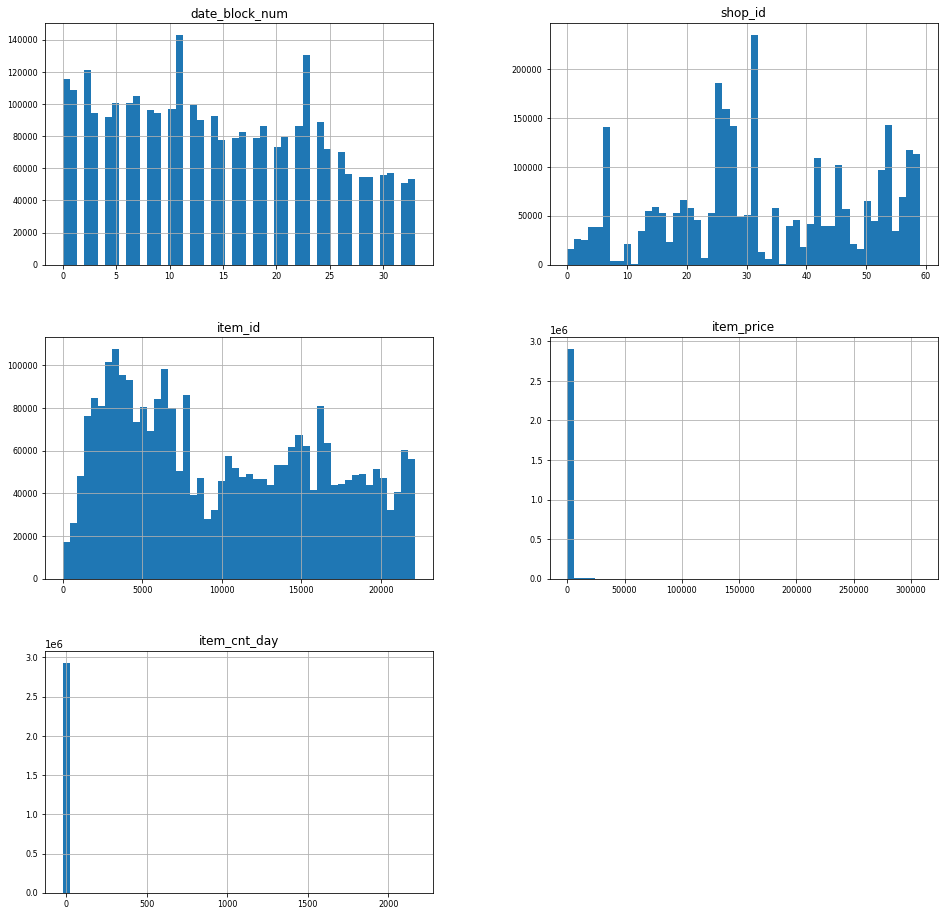

In [7]:
# sales train insights
eda(train_data)
graph_insight(train_data)

- date_block_num 그래프를 보면 연말마다 숫자가 많습니다. month에 영향을 미치는 것을 알 수 있습니다.

In [8]:
test.head(5) 

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [9]:
item_category.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
items.head(5) 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
sub.head(5)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [13]:
print("train data 중복 수:",sum(train_data.duplicated()))

print("test  data 중복 수:",sum(test.duplicated()))

train data 중복 수: 6
test  data 중복 수: 0


### 중복 행 출력

In [14]:
train_data[train_data.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


### 중복 행 제거

In [15]:
# 중복 제거
train_data.drop_duplicates(inplace=True)

In [16]:
# 중복 재확인
sum(train_data.duplicated())

0

### 결측치 확인

In [17]:
#train데이터 결측치 확인
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [18]:
#test데이터 결측치 확인
test.isnull().sum()

shop_id    0
item_id    0
dtype: int64

### outlier (극단치) 제거

- **극단치**란
통계적 자료 분석의 결과를 왜곡시키거나, 자료 분석의 적절성을 위협하는 변숫값입니다.

- 1000과 2000이상의 동떨어진 데이터 들이 존재합니다.
- 우리는 500이하로 범위로 좁혀주겠습니다.

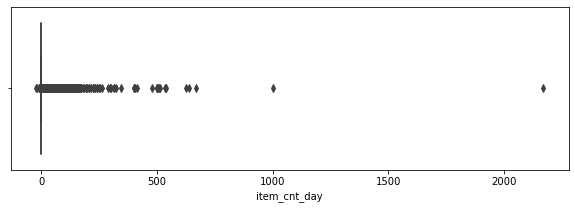

In [19]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train_data);

In [20]:
#outlier (극단치) 제거
train_data = train_data[train_data.item_cnt_day < 500]

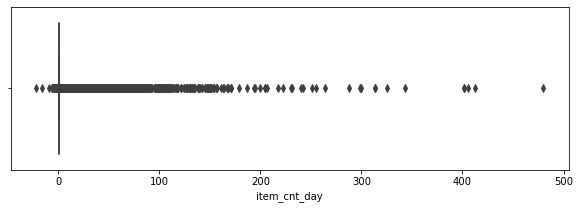

In [21]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train_data);

### 음수값 제거

- item_cnt_day와 item_price의 음수값을 제거합니다.

In [22]:
train_data = train_data[train_data.item_cnt_day >= 0]

train_data = train_data[train_data.item_price >= 0]

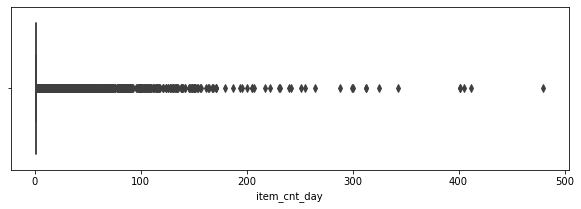

In [23]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train_data);

In [24]:
print('train data dim : {}'.format(train_data.shape))

train data dim : (2928472, 6)


item_cnt_day에 대한 이상치 제거   
2935849 -> 2928473로 변경 

item_pirce에 대한 이상치 제거 
2928473 -> 2928469로 변경

In [25]:
# train_data.drop(['item_price','date'], axis=1)

# Test set

test data는 34번째 date_block_num입니다.

In [26]:
test['date_block_num'] = '34'
test['date_block_num'] = test['date_block_num'].apply(int)
test

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34


## merge train/test data

In [27]:
total_data = pd.concat([train_data, test], ignore_index=True, sort=False)
total_data.fillna(0, inplace=True) # 34 month

In [28]:
total_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,06.01.2013,0,25,2554,1709.05,1.0
3,15.01.2013,0,25,2555,1099.00,1.0
4,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
3142667,0,34,45,18454,0.00,0.0
3142668,0,34,45,16188,0.00,0.0
3142669,0,34,45,15757,0.00,0.0
3142670,0,34,45,19648,0.00,0.0


## category column 추가

- item_category_name의 이름에 각 카테고리는 type과 subtype이 존재합니다.
- LableEncoder를 사용하여 문자를 숫자로 변환합니다.

In [29]:
# (e.g., type: Аксессуары subtype: PS2)
item_category['split'] = item_category['item_category_name'].str.split('-')
item_category['type'] = item_category['split'].map(lambda x: x[0].strip())
item_category['type_code'] = LabelEncoder().fit_transform(item_category['type'])
# if subtype is nan then type
item_category['subtype'] = item_category['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_category['subtype_code'] = LabelEncoder().fit_transform(item_category['subtype'])
item_category = item_category[['item_category_id','type_code', 'subtype_code']]

In [30]:
item_category

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
...,...,...,...
79,79,16,54
80,80,16,25
81,81,17,62
82,82,18,63


## merge shops/items/item_category data

- total_data에 shops/items/item_category data 추가하였습니다.
- 'item_cnt_day' 컬럼명 'item_cnt_month'로 변경하였습니다.

In [31]:
total_data = pd.merge(total_data, shops, on=['shop_id'], how='left')
total_data = pd.merge(total_data, items, on=['item_id'], how='left')
total_data = pd.merge(total_data, item_category, on=['item_category_id'], how='left')
total_data['item_cnt_month'] = total_data['item_cnt_day']
total_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,type_code,subtype_code,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,11,1,1.0
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,13,27,1.0
2,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,13,27,1.0
3,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,13,3,1.0
4,10.01.2013,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,13,40,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3142667,0,34,45,18454,0.00,0.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,13,2,0.0
3142668,0,34,45,16188,0.00,0.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,14,42,0.0
3142669,0,34,45,15757,0.00,0.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,13,2,0.0
3142670,0,34,45,19648,0.00,0.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,11,4,0.0


## month 칼럼 추가

In [32]:
total_data['month'] = total_data['date_block_num'] % 12
total_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,type_code,subtype_code,item_cnt_month,month
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,11,1,1.0,0
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,13,27,1.0,0
2,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,13,27,1.0,0
3,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,13,3,1.0,0
4,10.01.2013,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,13,40,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142667,0,34,45,18454,0.00,0.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,13,2,0.0,10
3142668,0,34,45,16188,0.00,0.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,14,42,0.0,10
3142669,0,34,45,15757,0.00,0.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,13,2,0.0,10
3142670,0,34,45,19648,0.00,0.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,11,4,0.0,10


## 불필요한 columns 제거

'date','item_price','shop_name','item_name' 칼럼을 제거하겠습니다.

In [33]:
total_data = total_data.drop(['date','item_price','shop_name','item_name'], axis=1)
total_data

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,type_code,subtype_code,item_cnt_month,month
0,0,59,22154,1.0,37,11,1,1.0,0
1,0,25,2552,1.0,58,13,27,1.0,0
2,0,25,2554,1.0,58,13,27,1.0,0
3,0,25,2555,1.0,56,13,3,1.0,0
4,0,25,2564,1.0,59,13,40,1.0,0
...,...,...,...,...,...,...,...,...,...
3142667,34,45,18454,0.0,55,13,2,0.0,10
3142668,34,45,16188,0.0,64,14,42,0.0,10
3142669,34,45,15757,0.0,55,13,2,0.0,10
3142670,34,45,19648,0.0,40,11,4,0.0,10


## 데이터 분리하기

- date_block_num을 기준으로 33 미만일 때 train data, 33일 때 validation data, 34일 때 test data로 total_data를 분리하였습니다.

In [34]:
X_train = total_data[total_data.date_block_num < 33].drop(['item_cnt_day'], axis=1)
Y_train = total_data[total_data.date_block_num < 33]['item_cnt_day']
X_valid = total_data[total_data.date_block_num == 33].drop(['item_cnt_day'], axis=1)
Y_valid = total_data[total_data.date_block_num == 33]['item_cnt_day']
X_test = total_data[total_data.date_block_num == 34].drop(['item_cnt_day'], axis=1)

# 모델 설계

- 하이퍼 파라미터는 그리드 서치를 이용하여 num_leaves, feature_fraction, bagging_fraction, min_data_in_leaf의 값이 선택되었습니다.
- regression 모델을 평가하기 위해 RMSE 방법을 사용하였습니다.
- 학습률은 0.01을 사용하였습니다.

## 1. Light GBM

In [35]:
import lightgbm as lgb

In [36]:
def build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, cat_features):
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_val = lgb.Dataset(X_valid, Y_valid)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [37]:
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 500,
    'early_stopping_rounds': 30,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['date_block_num','shop_id','item_id','item_category_id','type_code','subtype_code','month']

lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, cat_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10523
[LightGBM] [Info] Number of data points in the train set: 2875088, number of used features: 8
[LightGBM] [Info] Start training from score 1.244319
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's rmse: 0.654879	valid_1's rmse: 0.627776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

## 2. XGBoost

In [43]:
from xgboost import XGBRegressor
model_2 = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model_2.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:1.86264	validation_1-rmse:1.71475
[1]	validation_0-rmse:1.68270	validation_1-rmse:1.54462
[2]	validation_0-rmse:1.51870	validation_1-rmse:1.39085
[3]	validation_0-rmse:1.37077	validation_1-rmse:1.25359
[4]	validation_0-rmse:1.23868	validation_1-rmse:1.12853
[5]	validation_0-rmse:1.11857	validation_1-rmse:1.01573
[6]	validation_0-rmse:1.01228	validation_1-rmse:0.91581
[7]	validation_0-rmse:0.91490	validation_1-rmse:0.82473
[8]	validation_0-rmse:0.88694	validation_1-rmse:0.80285
[9]	validation_0-rmse:0.80447	validation_1-rmse:0.72347
[10]	validation_0-rmse:0.72796	validation_1-rmse:0.65312
[11]	validation_0-rmse:0.65847	validation_1-rmse:0.58871
[12]	validation_0-rmse:0.64385	validation_1-rmse:0.57239
[13]	validation_0-rmse:0.58325	validation_1-rmse:0.51655
[14]	validation_0-rmse:0.57010	validation_1-rmse:0.50485
[15]	validation_0-rmse:0.51661	validation_1-rmse:0.45676
[16]	validation_0-rmse:0.46797	validation_1-rmse:0.41379
[17]	validation_0-rmse:0.42403	validation

KeyError: 'base_score'

KeyError: 'base_score'

## Submission

In [44]:
# Light GBM

Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgb_submission.csv', index=False)
submission.head()

,ID,item_cnt_month
0,0,1.001406
1,1,1.001524
2,2,1.003240
3,3,1.003647
4,4,0.986845


In [45]:
# XGBoost

Y_pred = model_2.predict(X_valid).clip(0, 20)
Y_test = model_2.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)
submission.head()

,ID,item_cnt_month
0,0,0.997215
1,1,1.022057
2,2,0.997215
3,3,0.997553
4,4,1.004519


## 캐글 Public Score 

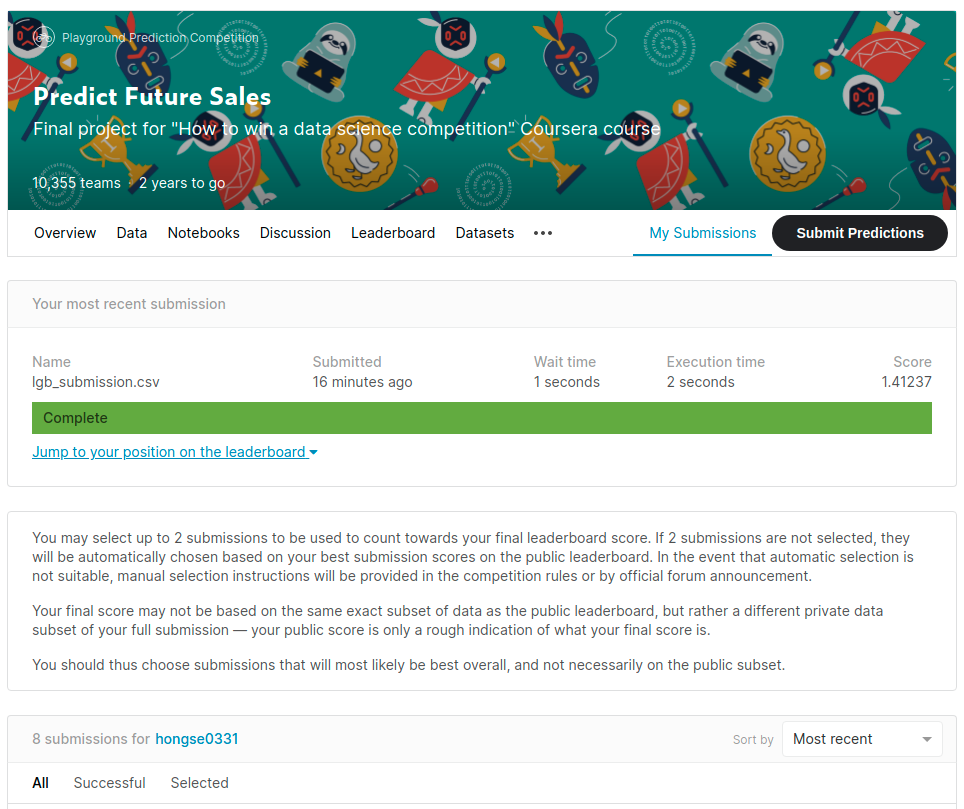

In [48]:
from IPython.display import Image
image_dir = os.getenv('HOME')+'/Desktop'
image_path = join(image_dir, 'kaggle_score.png')
image_path_2 = join(image_dir, 'public_leaderboard.png')
Image(image_path)

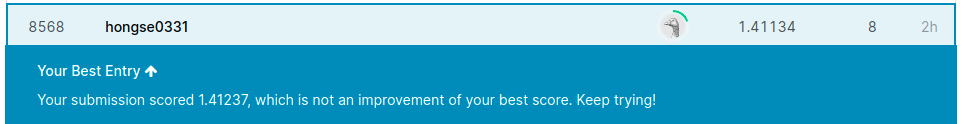

In [49]:
Image(image_path_2)

캐글 public score는 1.41237이 나왔습니다.

# 시도해본 것들

https://github.com/goeun-lee-get/ai-on-the-hill/blob/master/%EC%8B%9C%EB%8F%84%ED%95%B4%EB%B3%B8%EA%B2%83%EB%93%A4.ipynb  (git-hub '시도해본것들')


이 링크의 방식은

train-set 에 대한 feature 칼럼을 만들고, test-set에 대한 feature 칼럼을 각각 만들어서 모델을 돌렸다. 현재 jupyter notebook 코드 방식은 train-set과 test-set의 merge한 후 한번에 feature 칼럼을 만들었다. 즉 코드의 효율이 더 좋기때문에 원본 코드를 채택하였다.

그리고 이 링크에서 시도 하였던것들을 간략하게 소개 하겠다.(7가지 시도)


1번째,2번째,3번째,4번째 시도는 GradientBoosting, XGBoost, LightGBM의 앙상블 방식을 사용하였다.

1번째 시도: [shop_id, item_id] feature 사용

2번째 시도: [shop_id, item_id, data_block_num, month, item_category_id] feature 사용

3번째 시도: item_cnt_month>12 인 경우의 train-set으로 사용하기

4번째 시도: [shop_id, item_id, data_block_num, month, item_category_id,city_code] 사용

-> city_code feature는 성능을 더 저하시켜준다.(삭제함)

5번째 시도: 캐글 도전! 위의 방식으로 socre 37 점수를 받았다. 3번째 시도에 사용한 item_cnt_month>12인 부분을 제거하였다 score점수 5.8로 변경

6번째 시도: 앙상블 기법인 아닌 단독 기법 사용 XGBRegressor

7번째 시도: 기존에는 val-set를 생성하지 않고 학습하였다. 7번 시도에서는 val - set 설정후, lightgbm모델로 시도 rmse4.7로 나왔다.

시도에 대한 상세한 결과를 보고 싶다면 링크에 접속하자.


# THE END !!!